## Effects of Model Complexity

One of the simplest models for classification is $k$-Nearest Neighbors (kNN). The premise of kNN is to classify a new unseen point $P$ by considering the $k$ neighboring points of $P$ and selecting the majority of the $k$ neighbors. In this notebook, we will investigate the effects of selecting different values of $k$ for kNN, and how this extrapolates to more general models.

### Bias
When evaluating a model, the most intuitive first step is to look at how well the model performs. For classification, this may be the percentage of data points correctly classified, or for regression it may be how close the predicted values are to actual. The **bias** of a model is a measure of how close our prediction is to the actual value on average from an average model. Note that bias is not a measure of a single model, it encapuslates the scenario in which we collect many datasets, create models for each dataset, and average the error over all of models. Bias is not a measure of error for a single model, but a more abstract concept describing the average error over all errors. A low value for the bias of a model describes that on average, our predictions are similar to the actual values.

### Variance
The **variance** of  a model relates to the variance of the distribution of all models. In the previous section about bias, we envisoned the scenario of collecting many datasets, creating models for each dataset, and averaging the error overall the datasets. Instead, the variance of a model describes the variance in prediction. While we might be able to predict a value very well on average, if the variance of predictions is very high this may not be very helpful, as when we train a model we only have one such instance, and a high model variance tells us little about the true nature of the predictions. A low variance describes that our model will not predict very different values for different datasets.


![alt text](BiasVariance.jpg "Bias Variance Visualization")

The image describes what bias and variance are in a more simplified example. Consider that we would like to create a model that selects a point close to the center. The models on the top row have low bias, meaning the center of the cluster is close to the red dot on the target. The models on the left column have low variance, the clusters are quite tight, meaning our predictions are close together.

What is the order of best scenarios?


## Bias and Variance in $k$-Nearest Neighbors

Let's investigate bias and variance in terms of kNN. A great dataset is the iris dataset, which contains three classes of irises and $50$ examples of each. The data set contains sepal and petal length and width. For the sake of clarity, I add some noise to the iris data so that the decision boundaries are not as clear.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

np.random.seed(189)

# From http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2]
X = X + 0.3*np.random.randn(X.shape[0], X.shape[1])
y = iris.target
h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])



n_neighbors = 1
weights ='uniform'


def kNNForIris(num_neighbors,X,y,mweights = "uniform"):
    plt.figure(figsize = (7,7))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # we create an instance of Neighbours Classifier and fit the data.

    clf = neighbors.KNeighborsClassifier(num_neighbors, weights=weights)
    
    clf.fit(X, y)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (num_neighbors, weights))
    plt.show()
    print("Training Accuracy: %.3f"%(clf.score(X,y)))

def determineError(X,Y,yTitle="Training Accuracy"):
    plt.figure(figsize = (7,7))

        
    errors = []
    for num_neighbors in range(1,X.shape[0]):
        clf = neighbors.KNeighborsClassifier(num_neighbors, weights=weights)
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        clf.fit(X,Y)

        error = clf.score(X,Y)
        errors.append(error)
    
    plt.plot(errors)
    plt.ylabel(yTitle)
    plt.xlabel('k Value')
    plt.show()
    return errors

## Test Different Values of k

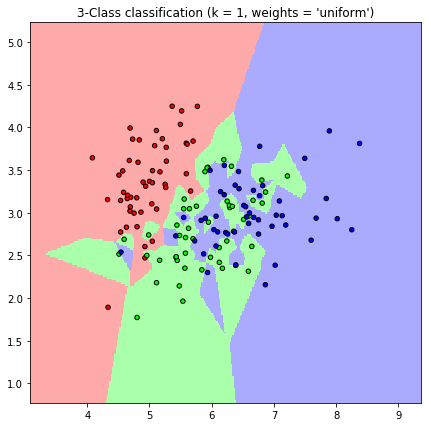

Training Accuracy: 1.000


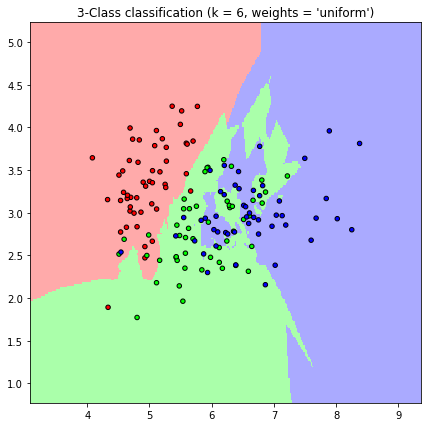

Training Accuracy: 0.807


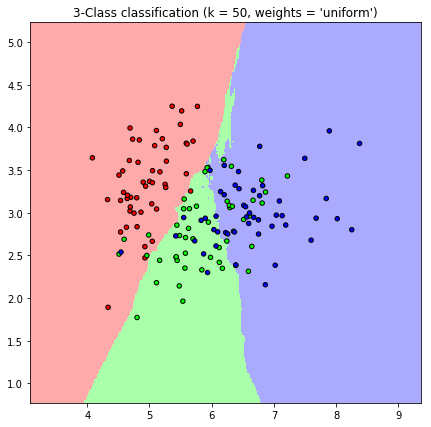

Training Accuracy: 0.767


In [2]:
kNNForIris(1,X,y)
kNNForIris(6,X,y)
kNNForIris(50,X,y)

## Decision boundaries in $k$-Nearest Neighbors

The plots above have red, green, and blue colored sections corresponding to **decision boundaries**. Decision boundaries are the boundaries in which a specific classication decision is chosen. For example, the red section represents the area where a new point would be classified as red, and similarly for blue and green. The decision boundary is the dividing line between the red and green sections. When comparing $k=1$ and $k=50$, there are major differences in the decision boundary. For $k=1$, the decision boundary is not a smooth and contains many small "islands of classification". The decision boundary is very complex and attempts to fit specifically to each data point. This is not necessary the best choice. If we consider $k=50$, then the decision boundary is far mor simple. The decision boundary is roughly composed of straight lines, for example the green region is roughly triangular.

How do we bring bias and variance into these plots?

## Bias in kNN
The bias for kNN can be thought of classification accuracy. For small values of $k$, our model performs exceptionally on the training data. $k=1$ even does perfect classification! For large values of $k$, our models performs quite poorly, hardly better than random guessing. Thus bias increases as $k$ increases.

Below is a plot of the training accuracy using the the training data to create decision boundaries and predict. The bias increases (accuracy is the opposite of error).

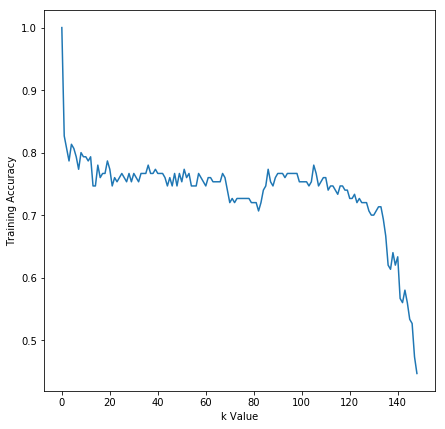

In [3]:
errors = determineError(X,y)

## Variance in kNN
Variance for kNN is best understood through the decision boundaries. With the smaller values of $k$, the decision boundaries are jagged and complex, but simple and straight for larger values of $k$. Thus variance decreases as $k$ increases. 

Below is a gif of the decision boundaries evolving as $k$ increases.
<img src="knn.gif" width="60%">

# Bias Variance Tradeoff

We have seen that increasing $k$ increases the bias but decreases the variance. But we want both low bias and variance! How do we balance bias and variance? This is known as the bias variance tradeoff. 

![alt text](BiasVarianceTradeoff.png "Bias Variance Tradeoff")

Image from http://scott.fortmann-roe.com/docs/BiasVariance.html


The optimal model is one that minimizes the sum of the $\text{bias}^2$ and variance. This is usually determined through testing various values and selecting the best one. A key notion of the trade off is that a central value is the best choice. When generating a model, it may seem that it is best to always minimize bias, because on average our models will do well. This is incorrect as in practice we only have one model (more on this later in the notebook!) and we would like consistent and good results with this single model. Although on average we may have low error, if we only have one opportunity it is very important to sacrifice some error to have greater confidence in our model.

**Questions for understanding**:
> 1. Where does underfitting and overfitting lie in the graph above? How do they relate to bias and variance?
> 2. Why can't we usually just make a bunch of models with low bias and high variance and average them?
> 3. Why is low variance important in models?